### Priority
* First, analyze and get the statistics for each df_cell
* Determine whether keep going with unit x state manner
* Attention is related to grasp the important pattern?
* Short chromosome can be mixed up in the sample?
* Prepare all the prerequisites before we enter the pretrain step

In [160]:
from platform import python_version
python_version()

'3.8.8'

In [161]:
# import torch 
# torch.cuda.is_available()

In [162]:
import os
import pandas as pd
import json
import tqdm
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [163]:
import pickle

In [164]:
import css_utility

In [165]:
from css_utility import colored_css_str

In [166]:
from css_utility import all_files, all_cell_pickles, state_col_dict
from css_utility import state_dict,css_name,css_dict,css_color_dict
from css_utility import file_list_maker,colors2color_dec,bed2df_as_is
from css_utility import bed2df_expanded,total_df_maker,numchr,df2css_allchr
from css_utility import df2chr_index,df2css_chr,df2css_chr_str,css_list2count
from css_utility import colored_css_str, css_name_col_dict

In [167]:
state_col_dict

{'A': (0.8588235294117647, 0.2235294117647059, 0.19607843137254902),
 'B': (0.8705882352941177, 0.3411764705882353, 0.21176470588235294),
 'C': (0.4196078431372549, 0.7333333333333333, 0.3411764705882353),
 'D': (0.2235294117647059, 0.48627450980392156, 0.2823529411764706),
 'E': (0.18823529411764706, 0.3843137254901961, 0.22745098039215686),
 'F': (0.7725490196078432, 0.8352941176470589, 0.3137254901960784),
 'G': (0.9607843137254902, 0.7686274509803922, 0.3843137254901961),
 'H': (0.5058823529411764, 0.7607843137254902, 0.6627450980392157),
 'I': (0.5372549019607843, 0.5607843137254902, 0.7411764705882353),
 'J': (0.7529411764705882, 0.3843137254901961, 0.37254901960784315),
 'K': (0.8745098039215686, 0.611764705882353, 0.4980392156862745),
 'L': (0.7372549019607844, 0.7137254901960784, 0.45098039215686275),
 'M': (0.5764705882352941, 0.5843137254901961, 0.6),
 'N': (0.7843137254901961, 0.792156862745098, 0.796078431372549),
 'O': (0.9411764705882353, 0.9411764705882353, 0.9411764705

In [171]:
colored_css_str(["A","B","C","D","O","F"])

A B C D O F 


In [168]:
### write and test the quiescent region removal

test_file_bed=all_files[0]
df=bed2df_expanded(test_file_bed)
print("test file name: ", test_file_bed)

test file name:  ../database/bed/unzipped/E001_15_coreMarks_stateno.bed


In [10]:
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [11]:
df["chromosome"].iloc[45244]

'chr2'

In [12]:
df[["chromosome","length","state_seq_full"]].iloc[:3]

,chromosome,length,state_seq_full
0,chr1,9800,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,800,IIIIIIII
2,chr1,529800,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [13]:
df[["chromosome","length","state_seq_full"]].iloc[45242:45245]

,chromosome,length,state_seq_full
45242,chr1,800,IIIIIIII
45243,chr1,10400,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45244,chr2,9800,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [14]:
# sort by the length of the state_seq_full (and analyze its distribution)
# 1. for one chromosome, group O only
# 2. bar graph for the length (distribution)
# 3. sort the length and see the index where it is located

In [15]:
df["chromosome"][0:45244].tail()

45239    chr1
45240    chr1
45241    chr1
45242    chr1
45243    chr1
Name: chromosome, dtype: object

In [16]:
df[0:45244].tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
45239,chr1,249211400,249212600,4,1200,12,D,DDDDDDDDDDDD
45240,chr1,249212600,249221200,5,8600,86,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
45241,chr1,249221200,249239400,15,18200,182,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45242,chr1,249239400,249240200,9,800,8,I,IIIIIIII
45243,chr1,249240200,249250600,15,10400,104,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [17]:
def df2chr_df(df):   # reflected
   
    """Create a list of dataframes, each of which containing 
    the the whole expanded type of dataframe per chromosome"""
    
    start=0
    df_chr_list=[]
    chr_index=df2chr_index(df)
    
    for index in chr_index:
        df_chr=df[start:index+1] # note that python [i:j] means from i to j-1
        chr_name=df["chromosome"].iloc[start] # string, such as chr1, chr2, ...
        df_name='df_'+chr_name  # the chromosome-wise data stored like df_chr1, df_chr2, ...
        locals()[df_name]=df_chr # make a string into a variable name
        df_chr_list.append(df_chr)
        start=index+1
    
    return df_chr_list      # elm is the df of each chromosome

In [18]:
df_chr_list=df2chr_df(df)

In [19]:
len(df_chr_list)

25

In [20]:
df_chr_list[0].tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
45239,chr1,249211400,249212600,4,1200,12,D,DDDDDDDDDDDD
45240,chr1,249212600,249221200,5,8600,86,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
45241,chr1,249221200,249239400,15,18200,182,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45242,chr1,249239400,249240200,9,800,8,I,IIIIIIII
45243,chr1,249240200,249250600,15,10400,104,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [21]:
chr1df=df_chr_list[0]

In [22]:
chr1df.tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
45239,chr1,249211400,249212600,4,1200,12,D,DDDDDDDDDDDD
45240,chr1,249212600,249221200,5,8600,86,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
45241,chr1,249221200,249239400,15,18200,182,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45242,chr1,249239400,249240200,9,800,8,I,IIIIIIII
45243,chr1,249240200,249250600,15,10400,104,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [23]:
len(chr1df)

45244

In [24]:
chr1df_o=chr1df[chr1df["state"]==15]
chr1df_o.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
6,chr1,570000,713800,15,143800,1438,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
11,chr1,727400,761600,15,34200,342,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [25]:
len(chr1df_o)

7512

In [26]:
chr1df_o_sorted=chr1df_o.sort_values(by=["length"], ascending=False)

In [27]:
chr1df_o_sorted.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
25286,chr1,121485600,142535200,15,21049600,210496,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3331,chr1,12846800,13784800,15,938000,9380,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
25362,chr1,144020000,144519200,15,499200,4992,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
22368,chr1,103717400,104043200,15,325800,3258,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [28]:
chr1df_o.loc[:,"unit"].describe()

count      7512.000000
mean        222.012780
std        2443.031224
min           2.000000
25%          58.000000
50%         116.000000
75%         228.000000
max      210496.000000
Name: unit, dtype: float64

In [29]:
chr1df_o.index

Int64Index([    0,     2,     4,     6,    11,    13,    17,   130,   132,
              138,
            ...
            45185, 45187, 45189, 45191, 45204, 45222, 45228, 45232, 45241,
            45243],
           dtype='int64', length=7512)

<AxesSubplot:>

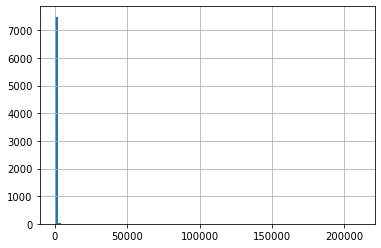

In [30]:
chr1df_o.loc[:,"unit"].hist(bins=100)

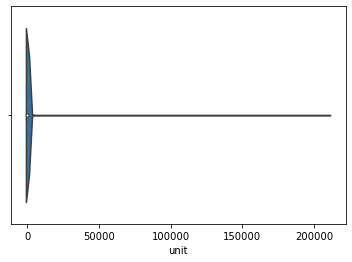

In [31]:
ax1=sns.violinplot(x=chr1df_o["unit"])

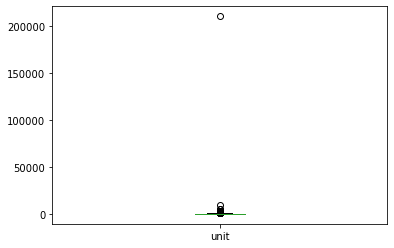

In [32]:
ax2=chr1df_o["unit"].plot.box()

In [33]:
chr1df_o_overmean=chr1df_o[chr1df_o["unit"]>chr1df_o["unit"].mean()]
len(chr1df_o_overmean)

1937

In [34]:
chr1df_o_overmean["unit"].describe()

count      1937.000000
mean        599.522974
std        4790.914402
min         224.000000
25%         282.000000
50%         368.000000
75%         538.000000
max      210496.000000
Name: unit, dtype: float64

In [35]:
##remove the 15th state from the df
df.head(100)

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
95,chr1,951000,951400,5,400,4,E,EEEE
96,chr1,951400,951800,8,400,4,H,HHHH
97,chr1,951800,955400,5,3600,36,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
98,chr1,955400,957000,1,1600,16,A,AAAAAAAAAAAAAAAA


In [36]:
df_wo_o=df[df["state"]!=15]

In [37]:
df_wo_o.head(10)

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
1,chr1,9800,10600,9,800,8,I,IIIIIIII
3,chr1,540400,540800,1,400,4,A,AAAA
5,chr1,569800,570000,9,200,2,I,II
7,chr1,713800,715200,1,1400,14,A,AAAAAAAAAAAAAA
8,chr1,715200,724000,5,8800,88,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
9,chr1,724000,725000,8,1000,10,H,HHHHHHHHHH
10,chr1,725000,727400,9,2400,24,I,IIIIIIIIIIIIIIIIIIIIIIII
12,chr1,761600,763200,1,1600,16,A,AAAAAAAAAAAAAAAA
14,chr1,779800,780400,7,600,6,G,GGGGGG
15,chr1,780400,780800,5,400,4,E,EEEE


In [38]:
df_wo_o.tail(10)

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
510137,chrY,58998400,59001400,14,3000,30,N,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
510138,chrY,59001400,59001800,10,400,4,J,JJJJ
510139,chrY,59001800,59002000,11,200,2,K,KK
510140,chrY,59002000,59002200,10,200,2,J,JJ
510141,chrY,59002200,59002400,13,200,2,M,MM
510142,chrY,59002400,59003200,14,800,8,N,NNNNNNNN
510143,chrY,59003200,59003600,9,400,4,I,IIII
510144,chrY,59003600,59003800,14,200,2,N,NN
510146,chrY,59005800,59006000,9,200,2,I,II
510148,chrY,59011800,59026000,9,14200,142,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [39]:
sample=df_wo_o.head(30)
sample  # sample is a part of df that consists of without the 15th state

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
1,chr1,9800,10600,9,800,8,I,IIIIIIII
3,chr1,540400,540800,1,400,4,A,AAAA
5,chr1,569800,570000,9,200,2,I,II
7,chr1,713800,715200,1,1400,14,A,AAAAAAAAAAAAAA
8,chr1,715200,724000,5,8800,88,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
9,chr1,724000,725000,8,1000,10,H,HHHHHHHHHH
10,chr1,725000,727400,9,2400,24,I,IIIIIIIIIIIIIIIIIIIIIIII
12,chr1,761600,763200,1,1600,16,A,AAAAAAAAAAAAAAAA
14,chr1,779800,780400,7,600,6,G,GGGGGG
15,chr1,780400,780800,5,400,4,E,EEEE


In [40]:
df_wo_o.tail()["state_seq_full"]

510142                                             NNNNNNNN
510143                                                 IIII
510144                                                   NN
510146                                                   II
510148    IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
Name: state_seq_full, dtype: object

In [41]:
lst=[]
str_elm=sample["state_seq_full"].iloc[0]
str_elm

'IIIIIIII'

In [42]:
# a test function to create a list, the elm of which is the connected-pattern of the chromatin state except for quiescent state

lst=[]
str_elm=sample["state_seq_full"].iloc[0]  # the very first elm
for i in range(1, len(sample)):
    # check the index first
    cid=sample.index[i] #init=1
    pid=sample.index[i-1] # init=0
    ssf=sample["state_seq_full"]
    if (cid-pid)!=1: # if the index is separated (not a succeeding numbers)
        lst.append(str_elm)
        str_elm=ssf.iloc[i]
    else:            # if encountered a consecutive index
        str_elm+=ssf.iloc[i] # attach the next str to the previous str
        if i==len(sample)-1:   # treat the final line
            lst.append(str_elm)
lst

['IIIIIIII',
 'AAAA',
 'II',
 'AAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHHHHHHHIIIIIIIIIIIIIIIIIIIIIIII',
 'AAAAAAAAAAAAAAAA',
 'GGGGGGEEEEGGGGGG',
 'GGGGGGBBNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMMMMMMNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNNNNNLLMMMMMMMMMMMMMMMMMMMMLLNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMJJJJLLMMMMMMMMMMMMLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM']

In [43]:
test_df=df.head(10)

In [44]:
test_df["state_seq_full"].index[1]

1

In [45]:
def df2inbetweeen_lst(df):  # subjected to the function "df2wo15list"
    lst=[]
    df_wo_o=df[df["state"]!=15]   #remove the 15th state from the css
    css_df=df_wo_o["state_seq_full"]
    str_elm=css_df.iloc[0]  # the very first elm
    for i in range(1, len(css_df)):
        # check the index first
        cid=css_df.index[i] #init=1
        pid=css_df.index[i-1] # init=0
        ssf=css_df
        if (cid-pid)!=1: # if the index is separated (not a succeeding numbers)
            lst.append(str_elm)
            str_elm=ssf.iloc[i]
        else:            # if encountered a consecutive index
            str_elm+=ssf.iloc[i] # attach the next str to the previous str
            if i==len(css_df)-1:   # treat the final line
                lst.append(str_elm)
    return lst

In [46]:
df2inbetweeen_lst(test_df)

['IIIIIIII',
 'AAAA',
 'II',
 'AAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHHHHHHH']

In [47]:
def df2wo15list(df):
    total_lst=[]
    df_chr_list=df2chr_df(df)   # a list, elm of which is the df of each chromosome
    for df_chr in df_chr_list:   # for each chromosome, create a grand list by adding up the whole
        lst_chr=df2inbetweeen_lst(df_chr)
        total_lst+=lst_chr
    return total_lst

In [48]:
test_lst_cre=df2wo15list(df)

In [49]:
len(test_lst_cre)

97546

In [50]:
test_elm_len=[]
for elm in test_lst_cre:
    test_elm_len.append(len(elm))
test_elm_len

[8,
 4,
 2,
 136,
 16,
 16,
 2224,
 20,
 82,
 774,
 1068,
 226,
 230,
 20,
 354,
 18,
 114,
 54,
 290,
 6,
 172,
 708,
 186,
 356,
 10,
 4,
 1912,
 238,
 184,
 8,
 238,
 130,
 188,
 370,
 12,
 12,
 124,
 2,
 16,
 440,
 60,
 154,
 392,
 476,
 52,
 652,
 34,
 4,
 658,
 388,
 28,
 110,
 674,
 264,
 20,
 58,
 142,
 8,
 26,
 106,
 108,
 10,
 44,
 52,
 24,
 170,
 72,
 562,
 194,
 38,
 16,
 18,
 76,
 594,
 176,
 1136,
 24,
 6,
 244,
 2,
 26,
 2158,
 14,
 408,
 124,
 274,
 26,
 22,
 88,
 8,
 48,
 12,
 8,
 28,
 6,
 8,
 20,
 4,
 18,
 32,
 4,
 34,
 28,
 18,
 2,
 2,
 40,
 6,
 20,
 12,
 24,
 30,
 2,
 8,
 42,
 156,
 34,
 10,
 114,
 8,
 8,
 22,
 8,
 8,
 50,
 14,
 6,
 14,
 18,
 8,
 26,
 2,
 2,
 22,
 8,
 10,
 10,
 8,
 8,
 12,
 22,
 18,
 4,
 8,
 26,
 30,
 22,
 70,
 18,
 10,
 4,
 4,
 42,
 102,
 30,
 6,
 22,
 4,
 8,
 8,
 10,
 4,
 92,
 24,
 60,
 2,
 8,
 8,
 2,
 604,
 6,
 8,
 12,
 104,
 16,
 8,
 12,
 8,
 60,
 10,
 4,
 74,
 90,
 86,
 126,
 4,
 8,
 10,
 508,
 8,
 136,
 8,
 66,
 94,
 702,
 416,
 74,
 1026,
 10

In [51]:
def css_elm_stat(total_lst):
    len_lst=[]
    for elm in total_lst:
        assert type(elm)==str, "element type is not string"
        len_lst.append(len(elm))
    print("total count: ", len(total_lst))
    print("max length: ", max(len_lst))
    print("min length: ", min(len_lst))
    print("average length: ",np.mean(len_lst))
    fig =plt.figure(figsize=(6,4))
    plt.hist(len_lst, bins=20, log=True, color="teal", edgecolor="white")
    plt.xlabel("length of chromatin state pattern", fontsize=14)
    plt.ylabel("Count", fontsize=14)

total count:  97546
max length:  5962
min length:  2
average length:  92.09630328255388


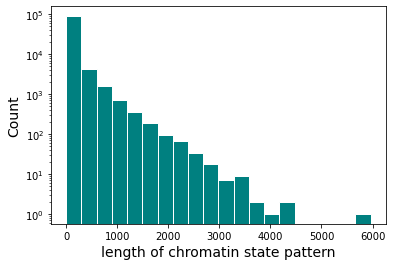

In [52]:
css_elm_stat(test_lst_cre)

In [55]:
def lst2let_compose(total_lst):
    letter_cnt=[]
    for word in total_lst:
        chk_let=word[0]
        num_let=1
        for let in word:
            if let!=chk_let:
                num_let+=1
                chk_let=let
        letter_cnt.append(num_let)
    print("total count: ", len(letter_cnt))
    print("max composition: ", max(letter_cnt))
    print("min composition: ", min(letter_cnt))
    print("average composition: ", np.mean(letter_cnt))
    fig =plt.figure(figsize=(6,4))
    plt.hist(letter_cnt, bins=20, log=True, color="orange", edgecolor="white")
    plt.xlabel("number of state in a composition", fontsize=14)
    plt.ylabel("Count", fontsize=14)

total count:  97546
max composition:  249
min composition:  1
average composition:  4.229307198654993


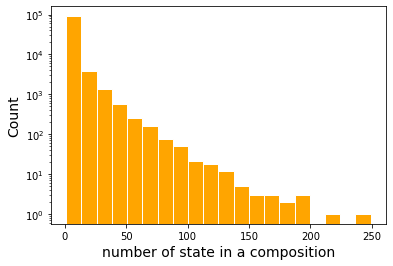

In [56]:
lst2let_compose(test_lst_cre)

In [58]:
def custom_colorlist(data_dict):
    
    """ 
    INPUT: solo chromatin state data in dict such as 
           data_dict={'I': 114, 'A': 23, 'N': 119, 'G': 33, 'E': 131, 'H': 1}
    OUTPUT: customized colormap according to ROADMAP (type=list)
    """
    state_list=list(data_dict.keys())
    colormap_list=[]
    assert type(state_list[0])==str
    for state in state_list:
        if css_dict[state] in css_name_col_dict.keys():
            color_rgb=css_name_col_dict[css_dict[state]]
            colormap_list.append(color_rgb)
    return colormap_list

In [91]:
# dict of lst and number (refer what is the main letter if there is only one composition )

def lst2cntdict(total_lst):
    letter_cnt=[]
    for word in total_lst:
        chk_let=word[0]
        num_let=1
        for let in word:
            if let!=chk_let:
                num_let+=1
                chk_let=let
        letter_cnt.append(num_let)
    css_lst_dict=dict(zip(total_lst, letter_cnt))
    return css_lst_dict

In [92]:
lst2cntdict(total_lst)

{'IIIIIIII': 1,
 'AAAA': 1,
 'II': 1,
 'AAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHHHHHHHIIIIIIIIIIIIIIIIIIIIIIII': 4,
 'AAAAAAAAAAAAAAAA': 1,
 'GGGGGGEEEEGGGGGG': 3,
 'GGGGGGBBNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMMMMMMNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNNNNNLLMMMMMMMMMMMMMMMMMMMMLLNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMJJJJLLMMMMMMMMMMMMLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMLLLLLLLLLLKKMMMMMMMMMMMMMMMMLLLLJJMMMMMMMMJJJJJJMMMMMMKKMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM

In [149]:
def lst2solo_compose(total_lst):# graph of a solo pattern frequency
    
    """INPUT: the entire list of in-between pattern w.o. 15th state (total_lst)
       OUTPUT: the most/least frequent solo pattern and the frequency graph
    """
    
    letter_cnt=[]
    for word in total_lst:
        chk_let=word[0]
        num_let=1
        for let in word:
            if let!=chk_let:
                num_let+=1
                chk_let=let
        letter_cnt.append(num_let)
    css_lst_dict=dict(zip(total_lst, letter_cnt))
    
    lst_for_solo=[]               # prepare to make a solo pattern list
    solo_dist={}                  # prepare to make a solo pattern length distribution dict
    for pattern, num in list(css_lst_dict.items()): # as a tuple element (key, val)
        if num==1:
            lst_for_solo.append(pattern[0])
            key=str(pattern[0])
            if key not in solo_dist.keys():
                solo_dist[key]=[len(pattern)]
            else:
                solo_dist[key].append(len(pattern))
                
    solo_counter=collections.Counter(lst_for_solo)
    solo_data_dict=dict(solo_counter) # ditionary of solo pattern and the frequency
    solo_data_dict=dict(sorted(solo_data_dict.items(), reverse=True, key=lambda item: item[1]))
    my_color=custom_colorlist(solo_data_dict)  # create a customized colormap using solo data
    
    for pattern, num in solo_data_dict.items():
        if num is max(solo_data_dict.values()):
            max_state=pattern
            max_num=num
        elif num is min(solo_data_dict.values()):
            min_state=pattern
            min_num=num

    print("frequency of solo pattern: ", len(lst_for_solo))
    print("the most frequent solo pattern: ", css_dict[max_state], " for ", max_num, " times appeared." )
    print("the least frequent solo pattern: ", css_dict[min_state], " for ", min_num, " times appeared." )
    
    x=[css_dict[state] for state in solo_data_dict.keys()]
    y=solo_data_dict.values()
    
    fig1 =plt.figure(figsize=(6,4))
    plt.bar(x,y, color=my_color)
    plt.xlabel("solo pattern", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    
    fig2, ax=plt.subplots(figsize=(6,4))
    solo_data=list(solo_dist.values())
    

frequency of solo pattern:  421
the most frequent solo pattern:  TxWk  for  131  times appeared.
the least frequent solo pattern:  ZNF/Rpts  for  1  times appeared.


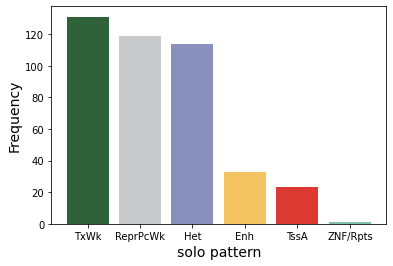

In [150]:
lst2solo_compose(total_lst)

{'bodies': [<matplotlib.collections.PolyCollection at 0x14f4c2634c40>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x14f4c26345b0>,
 'cmins': <matplotlib.collections.LineCollection at 0x14f4c2201880>,
 'cbars': <matplotlib.collections.LineCollection at 0x14f4c2201700>,
 'cmedians': <matplotlib.collections.LineCollection at 0x14f4c2201100>}

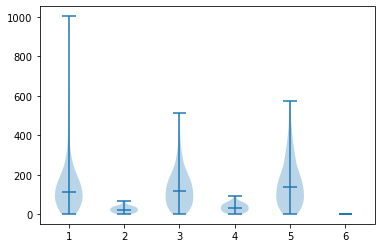

In [155]:
fig2, ax=plt.subplots(figsize=(6,4))
solo_data=list(solo_dist.values())
ax.violinplot(solo_data,showmeans=False, showmedians=True)

In [156]:
solo_data_dict

NameError: name 'solo_data_dict' is not defined

In [147]:
my_pal=custom_colorlist(solo_dist)

In [153]:
solo_data

[[8,
  2,
  20,
  18,
  16,
  28,
  10,
  52,
  24,
  14,
  26,
  22,
  12,
  32,
  4,
  40,
  34,
  50,
  6,
  30,
  42,
  62,
  58,
  36,
  60,
  46,
  72,
  56,
  64,
  44,
  90,
  86,
  78,
  54,
  38,
  84,
  70,
  98,
  66,
  48,
  68,
  76,
  108,
  96,
  88,
  116,
  102,
  80,
  74,
  104,
  164,
  94,
  110,
  82,
  136,
  122,
  132,
  100,
  106,
  176,
  118,
  142,
  194,
  114,
  124,
  112,
  144,
  304,
  126,
  92,
  134,
  120,
  138,
  140,
  128,
  382,
  1004,
  130,
  218,
  186,
  148,
  234,
  530,
  160,
  328,
  184,
  158,
  220,
  272,
  208,
  196,
  276,
  152,
  238,
  178,
  170,
  192,
  156,
  286,
  390,
  244,
  462,
  202,
  206,
  172,
  166,
  150,
  162,
  312,
  242,
  182,
  146,
  268,
  180],
 [4,
  16,
  6,
  10,
  14,
  18,
  28,
  26,
  8,
  12,
  20,
  24,
  32,
  42,
  30,
  2,
  22,
  36,
  66,
  34,
  38,
  44,
  40],
 [4,
  58,
  142,
  26,
  108,
  44,
  72,
  194,
  30,
  2,
  136,
  54,
  36,
  18,
  34,
  10,
  8,
  46,
  96,
  2

In [59]:
css_name_col_dict

{'TssA': (0.8588235294117647, 0.2235294117647059, 0.19607843137254902),
 'TssAFlnk': (0.8705882352941177, 0.3411764705882353, 0.21176470588235294),
 'TxFlnk': (0.4196078431372549, 0.7333333333333333, 0.3411764705882353),
 'Tx': (0.2235294117647059, 0.48627450980392156, 0.2823529411764706),
 'TxWk': (0.18823529411764706, 0.3843137254901961, 0.22745098039215686),
 'EnhG': (0.7725490196078432, 0.8352941176470589, 0.3137254901960784),
 'Enh': (0.9607843137254902, 0.7686274509803922, 0.3843137254901961),
 'ZNF/Rpts': (0.5058823529411764, 0.7607843137254902, 0.6627450980392157),
 'Het': (0.5372549019607843, 0.5607843137254902, 0.7411764705882353),
 'TssBiv': (0.7529411764705882, 0.3843137254901961, 0.37254901960784315),
 'BivFlnk': (0.8745098039215686, 0.611764705882353, 0.4980392156862745),
 'EnhBiv': (0.7372549019607844, 0.7137254901960784, 0.45098039215686275),
 'ReprPC': (0.5764705882352941, 0.5843137254901961, 0.6),
 'ReprPcWk': (0.7843137254901961, 0.792156862745098, 0.796078431372549)

In [60]:
total_lst=df2wo15list(df)

In [61]:
css_lst_dict=lst2cntdict(total_lst)

In [62]:
import collections

In [93]:
lst_for_solo=[]
for pattern, num in list(css_lst_dict.items()):
    if num==1:
        lst_for_solo.append(pattern[0])
lst_for_solo

['I',
 'A',
 'I',
 'A',
 'I',
 'I',
 'A',
 'A',
 'N',
 'I',
 'G',
 'I',
 'N',
 'N',
 'N',
 'N',
 'I',
 'N',
 'I',
 'I',
 'N',
 'N',
 'G',
 'I',
 'I',
 'I',
 'G',
 'I',
 'G',
 'G',
 'I',
 'I',
 'I',
 'N',
 'N',
 'I',
 'G',
 'G',
 'I',
 'I',
 'G',
 'G',
 'I',
 'I',
 'E',
 'N',
 'G',
 'I',
 'N',
 'A',
 'G',
 'N',
 'N',
 'N',
 'G',
 'N',
 'N',
 'I',
 'N',
 'N',
 'I',
 'I',
 'G',
 'I',
 'E',
 'I',
 'N',
 'I',
 'N',
 'N',
 'N',
 'I',
 'I',
 'I',
 'N',
 'E',
 'E',
 'N',
 'N',
 'G',
 'G',
 'E',
 'A',
 'E',
 'N',
 'G',
 'I',
 'N',
 'I',
 'I',
 'I',
 'E',
 'N',
 'E',
 'E',
 'E',
 'I',
 'E',
 'A',
 'N',
 'A',
 'N',
 'I',
 'I',
 'E',
 'I',
 'E',
 'N',
 'E',
 'E',
 'E',
 'I',
 'I',
 'A',
 'I',
 'E',
 'A',
 'G',
 'E',
 'A',
 'E',
 'E',
 'N',
 'G',
 'A',
 'I',
 'A',
 'N',
 'E',
 'A',
 'E',
 'N',
 'E',
 'A',
 'N',
 'N',
 'N',
 'N',
 'E',
 'I',
 'E',
 'G',
 'E',
 'A',
 'N',
 'A',
 'N',
 'N',
 'N',
 'E',
 'N',
 'I',
 'I',
 'E',
 'G',
 'N',
 'G',
 'G',
 'I',
 'A',
 'I',
 'E',
 'I',
 'E',
 'E',
 'G',
 'G'

In [120]:
solo_dist={}
type(solo_dist)

dict

In [135]:
solo_dist={}
for pattern, num in list(css_lst_dict.items()):
    if num==1:
        key=str(pattern[0])
        if key not in solo_dist.keys():
            solo_dist[key]=[len(pattern)]
        else:
            solo_dist[key].append(len(pattern))

In [ ]:
for key, value in solo_dist.items():
    solo_df=pd.DataFrame

In [143]:
solo_df=pd.DataFrame({key:pd.Series(value) for key, value in solo_dist.items()})


<AxesSubplot:>

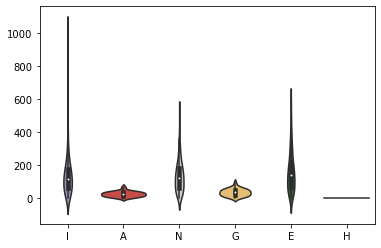

In [148]:
sns.violinplot(data=solo_df, palette=my_pal)

In [138]:
import seaborn as sns

In [140]:
sns.violinplot(x=solo_dist.keys(), y=solo_dist.values(), data=solo_dist)

TypeError: unhashable type: 'dict_keys'

In [122]:
sam_dict={'IIIIIIII': 1,
 'AAAA': 1,
 'II': 1,
 'AAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHHHHHHHIIIIIIIIIIIIIIIIIIIIIIII': 4,
 'AAAAAAAAAAAAAAAA': 1,
 'GGGGGGEEEEGGGGGG': 3}

In [64]:
counter=collections.Counter(lst_for_solo)
print(dict(counter))

{'I': 114, 'A': 23, 'N': 119, 'G': 33, 'E': 131, 'H': 1}


In [123]:
sam_dict

{'IIIIIIII': 1,
 'AAAA': 1,
 'II': 1,
 'AAAAAAAAAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHHHHHHHIIIIIIIIIIIIIIIIIIIIIIII': 4,
 'AAAAAAAAAAAAAAAA': 1,
 'GGGGGGEEEEGGGGGG': 3}

In [ ]:
sam_solo={"I":[8,2],"A":[4,16]}

In [132]:
test_dict={}

In [133]:
test_dict["A"]=[5]
test_dict

{'A': [5]}

In [134]:
test_dict["A"].append(6)
test_dict

{'A': [5, 6]}

In [131]:
test_dict

{'A': None}

In [79]:
# input= dataframe, output=a list of segmented css except for 15th state

def df2segment_index_bad(df):
    """Generate two lists: 15 state start point list / end point list
    input should be a df """
    total_row=len(df)
    state_o_start=[]
    state_o_end=[]
    
    # collect the start and end index where state=15
    for row_num in range(total_row-1):
        if (df["state"].iloc[row_num]==15):
            if row_num==0:
                state_o_start.append(row_num)
            elif (row_num<total_row-1) & (df["state"].iloc[row_num-1]!=15): # middle position: when 15 stars
                state_o_start.append(row_num)
            elif (row_num<total_row-1) & (df["state"].iloc[row_num+1]!=15): # middle position: when 15 ends
                state_o_end.append(row_num)
            elif row_num==total_row-1:
                state_o_end.append(row_num)
    return state_o_start, state_o_end

In [ ]:
# the above code is not good. Obtain just the location of 15, and then find the start and end index
# of the "other" states

# maybe good for the chromosome-wise df?
def df2segment_index(df):
    total_index=df.index
    rem_index=df[df["state"]!=15].index  # a list of index where state=15
    solo_list=[]
    conn_list=[]
    
    # then the start should be the "between" of these indices
    for row_num in rem_index:
        if (row_num+1 not in rem_index) & (row_num-1 not in rem_index):  # solo-list
            solos_list.append(df["state_seq_full"].iloc[row_num])
        elif:
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
        
            
    


In [108]:
total_index=df.index
o_index=df[df["state"]==15].index
rem_index=df[df["state"]!=15].index

In [110]:
rem_index

Int64Index([     1,      3,      5,      7,      8,      9,     10,     12,
                14,     15,
            ...
            510137, 510138, 510139, 510140, 510141, 510142, 510143, 510144,
            510146, 510148],
           dtype='int64', length=412566)

In [7]:
def all_chr2txt(all_chr_css, cell_num):
    """Generate a txt file from the all connected css."""
    cell_num=str(cell_num)
    file_name="../database/css_txt/css_all_"+cell_num+".txt"
    with open(file_name, "w") as f:
        f.write(all_chr_css)
    f.close()

In [31]:
def pickle2all_css(pickle, file_name, path2save):
    """Convert pickle dataframe into all-chromosome connected css and save it as .txt"""
    df=pd.read_pickle(pickle)
    all_chr_css=df2css_allchr(df)
    cell_num=re.findall(r'\d+',file_name)[0] #[0] added to extract the elm only   
    
    def all_chr2txt(all_chr_css, cell_num, path2save):
        """Generate a txt file from the all connected css.
        under the folder ../database/css_txt/ """
        assert (type(path2save)==str), "path should be string type"
        assert type(cell_num)==str, "cell number should be string type"
        file_name=path2save+"css_all_"+cell_num+".txt"
        with open(file_name, "w") as f:
            f.write(all_chr_css)
        f.close()
    
    all_chr2txt(all_chr_css, cell_num, path2save)
    return ("all files are saved in "+path2save)
    

In [23]:
cell_num_list=[]
for file_name in all_cell_pickles:
    cell_num=re.findall(r'\d+',file_name)
    cell_num_list.append(cell_num[0]) #[0] added to extract the elm only
print(cell_num_list)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127']


In [30]:
re.findall(r'\d+',file_name)[0]

'127'

In [27]:
assert type(cell_num_list[0][0])!=str 

In [9]:
all_cell_pickles[0]

'../database/cell_pickle/df_cell001.pkl'

In [10]:
all_cell_pickles[0]

'../database/cell_pickle/df_cell001.pkl'

In [11]:
import re

In [12]:
re.findall(r'\d+', all_cell_pickles[0])

['001']

#### Transform into Dataframe from bed file

In [15]:
test_file_bed=all_files[0]
test_file_bed

'../database/bed/unzipped/E001_15_coreMarks_stateno.bed'

In [16]:
df_test1=bed2df_as_is(test_file_bed)
df_test1.head()

,chromosome,start,end,state
0,chr1,0,9800,15
1,chr1,9800,10600,9
2,chr1,10600,540400,15
3,chr1,540400,540800,1
4,chr1,540800,569800,15


In [17]:
df_test1ex=bed2df_expanded(test_file_bed)
df_test1ex.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


#### Read pickled file (unpickling)

In [18]:
df=pd.read_pickle("../database/cell_pickle/df_cell001.pkl")
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [19]:
state_seq_full_to_str=df2css_allchr(df)

#### State initial and normalized RGB
*colors2color_dec*

In [20]:
state_col_dict

{'A': (0.8588235294117647, 0.2235294117647059, 0.19607843137254902),
 'B': (0.8705882352941177, 0.3411764705882353, 0.21176470588235294),
 'C': (0.4196078431372549, 0.7333333333333333, 0.3411764705882353),
 'D': (0.2235294117647059, 0.48627450980392156, 0.2823529411764706),
 'E': (0.18823529411764706, 0.3843137254901961, 0.22745098039215686),
 'F': (0.7725490196078432, 0.8352941176470589, 0.3137254901960784),
 'G': (0.9607843137254902, 0.7686274509803922, 0.3843137254901961),
 'H': (0.5058823529411764, 0.7607843137254902, 0.6627450980392157),
 'I': (0.5372549019607843, 0.5607843137254902, 0.7411764705882353),
 'J': (0.7529411764705882, 0.3843137254901961, 0.37254901960784315),
 'K': (0.8745098039215686, 0.611764705882353, 0.4980392156862745),
 'L': (0.7372549019607844, 0.7137254901960784, 0.45098039215686275),
 'M': (0.5764705882352941, 0.5843137254901961, 0.6),
 'N': (0.7843137254901961, 0.792156862745098, 0.796078431372549),
 'O': (0.9411764705882353, 0.9411764705882353, 0.9411764705

#### Number of chromosome
*numchr*

In [21]:
num_chromosome=numchr(df)
num_chromosome

25

#### Create a large piece of string of the whole state_seq_full in a cell
*df2css_allchar*

In [22]:
all_chr_css=df2css_allchr(df)
all_chr_css[10000:10200]

'MMMMMMMMMMMMKKMMMMMMMMMMMMMMMMMMMMMMMMJJJJJJJJJJJJMMMMMMMMLLLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNJJJJJJAAAAAAOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

In [23]:
colored_css_str(all_chr_css[11200:13900])

N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N O O O O O O O O O O O O O O O O O O O O I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N M M M M M M L L M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N G G E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E D D E E E E E E E E E E E E D D D D D D D D E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E A A A A A A A A A A A A N N N N N N N N M M M M M M M M N N N N N N N N N N 

In [32]:
def all_chr2txt(all_chr_css, cell_num):
    """Generate a txt file from the all connected css."""
    cell_num=str(cell_num)
    file_name="css_all_"+cell_num+".txt"
    with open(file_name, "w") as f:
        f.write(all_chr_css)
    f.close()

In [ ]:
## total pickle file list maker
def pickle_list_maker(pickle_path):
    

In [33]:
pickle_path='../database/cell_pickle'

In [38]:
pickle_files=os.listdir(pickle_path)

In [65]:
pickle_path

'../database/cell_pickle'

In [30]:
## save it as a file
with open("test_css2txt.txt","w") as ws:
    ws.write(all_chr_css)

In [31]:
ws.close()

#### Create CSS chromosome-wise
* *df2char_index* : the index (row no.) where each chromosome ends <br>
* *df2css_chr* : create a list of **dataframes**, each of which contains chromosome names and state_seq_full <br>
* *df2css_chr_str* : create a list of **strings** of state_seq_full, all connected per chromosome

In [15]:
chr_index=df2chr_index(df)
chr_index

[45243,
 84706,
 118779,
 146272,
 175237,
 204827,
 231085,
 254353,
 275223,
 298155,
 323185,
 348498,
 362434,
 378184,
 393196,
 408978,
 431073,
 442950,
 459355,
 471900,
 477268,
 486157,
 486165,
 509936,
 510149]

In [221]:
df_chr_list=df2css_chr(df)

In [222]:
df_chr_list[2].head()

,chromosome,state_seq_full
84707,chr3,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
84708,chr3,GGGG
84709,chr3,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
84710,chr3,GGGGGGGGGGGGGG
84711,chr3,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [223]:
chr_css_list=df2css_chr_str(df)

In [224]:
chr_css_list[2][1000:1200]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGGGGGGGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

#### CSS Pattern analysis
*css_list2count* 
* input: df, chr_css_list
* output; count_all (a dataframe where row=states, column=chromosomes)

In [225]:
count_all=css_list2count(df, chr_css_list)

In [226]:
count_all

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
A,29630,21000,18162,13428,15666,20234,15376,11350,11672,12044,...,11660,14596,5258,20840,7282,3020,5706,0,13860,44
B,8286,5596,5070,3576,4214,4918,3694,3162,3076,3298,...,2540,4842,1544,2798,2178,730,1596,0,3744,0
C,1092,410,578,426,588,712,392,328,332,240,...,164,486,128,354,302,64,94,0,476,4
D,48450,28844,24862,13432,21428,17066,18322,14210,17464,18234,...,20024,34246,5556,19834,14288,5330,11592,0,10668,6
E,401910,350518,312084,223202,241968,248700,237870,179962,186804,187476,...,148230,186618,97808,142212,111134,43898,90434,0,171668,290
F,2872,1598,1892,1194,1782,1476,1450,1416,1178,1522,...,730,2074,456,912,1044,314,600,0,1016,0
G,105692,93098,86782,63048,70438,72130,58276,54310,48378,52250,...,32706,44466,30376,17742,26694,11236,19116,0,52596,0
H,4558,4890,3684,4278,3860,3720,4912,3222,3022,4744,...,3432,2190,1232,10128,1328,1678,790,2,4726,2188
I,54650,65612,54810,59348,55184,46736,46958,44752,27308,36088,...,17968,20010,19642,35424,11958,11804,6264,58,61612,1462
J,11378,9264,6042,5692,6302,7318,5884,5558,5294,6544,...,4090,7662,2744,6398,3448,1266,2264,0,3786,26


In [227]:
count_all_renamed=count_all.rename(index=css_dict)

In [228]:
count_all_renamed

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
TssA,29630,21000,18162,13428,15666,20234,15376,11350,11672,12044,...,11660,14596,5258,20840,7282,3020,5706,0,13860,44
TssAFlnk,8286,5596,5070,3576,4214,4918,3694,3162,3076,3298,...,2540,4842,1544,2798,2178,730,1596,0,3744,0
TxFlnk,1092,410,578,426,588,712,392,328,332,240,...,164,486,128,354,302,64,94,0,476,4
Tx,48450,28844,24862,13432,21428,17066,18322,14210,17464,18234,...,20024,34246,5556,19834,14288,5330,11592,0,10668,6
TxWk,401910,350518,312084,223202,241968,248700,237870,179962,186804,187476,...,148230,186618,97808,142212,111134,43898,90434,0,171668,290
EnhG,2872,1598,1892,1194,1782,1476,1450,1416,1178,1522,...,730,2074,456,912,1044,314,600,0,1016,0
Enh,105692,93098,86782,63048,70438,72130,58276,54310,48378,52250,...,32706,44466,30376,17742,26694,11236,19116,0,52596,0
ZNF/Rpts,4558,4890,3684,4278,3860,3720,4912,3222,3022,4744,...,3432,2190,1232,10128,1328,1678,790,2,4726,2188
Het,54650,65612,54810,59348,55184,46736,46958,44752,27308,36088,...,17968,20010,19642,35424,11958,11804,6264,58,61612,1462
TssBiv,11378,9264,6042,5692,6302,7318,5884,5558,5294,6544,...,4090,7662,2744,6398,3448,1266,2264,0,3786,26


In [254]:
# create a def to draw the content of chromatin state per chromosome using count_all
def draw_count_barplot_incl15(count_all, chr_no):
    
    """ Draw a bar plot (chromatin state vs. count) per chromosome
    input(1) table of 'count_all' which is created by the function css_list2count(df, chr_css_list) 
    input(2) chromosome name in string, e.g.) 'chr1', 'chr2', ... 
    output: bar plot of the all chromatin state count (including 15th state)"""

    count_all_renamed=count_all.rename(index=css_dict)
    color_dec=colors2color_dec(css_color_dict)
    ax0=count_all_renamed.loc[:,chr_no].plot.bar(rot=45, color=color_dec)
    ax0.set_ylabel("Counts", fontsize=14)
    

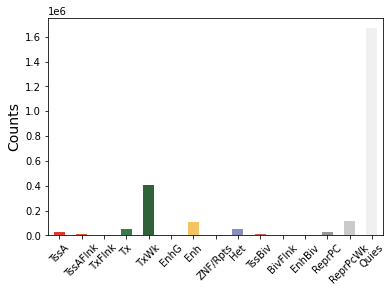

In [255]:
draw_count_barplot_incl15(count_all, "chr1")

In [256]:
def draw_count_barplot_wo15(count_all, chr_no):
    
    """ Draw a bar plot (chromatin state vs. count) per chromosome
    input(1) table of 'count_all' which is created by the function css_list2count(df, chr_css_list) 
    input(2) chromosome name in string, e.g.) 'chr1', 'chr2', ... 
    output: bar plot of the all chromatin state count except for 15th state"""

    count_all_renamed=count_all.rename(index=css_dict)
    color_dec=colors2color_dec(css_color_dict)
    ax0=count_all_renamed.loc[:,chr_no][:-1].plot.bar(rot=45, color=color_dec)
    ax0.set_ylabel("Counts", fontsize=14)

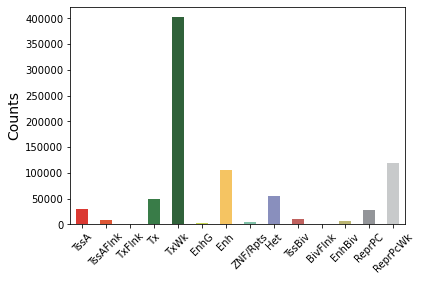

In [257]:
draw_count_barplot_wo15(count_all, "chr1")

In [28]:
count_all.sum().sum()  # total number of css contained in 1 cell sample

30956914

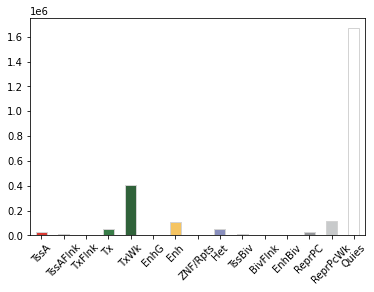

In [55]:
color_dec=colors2color_dec(css_color_dict)
ax0=count_all_renamed.loc[:,"chr1"].plot.bar(rot=45, color=color_dec, edgecolor="lightgray")  # total state

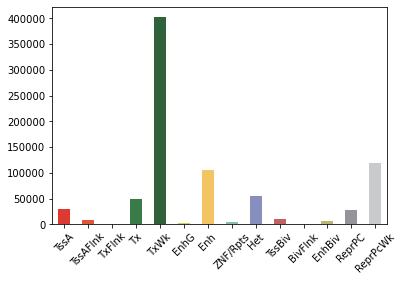

In [56]:
ax1=count_all_renamed.loc[:,"chr1"][:-1].plot.bar(rot=45, color=color_dec)  # except for Quies

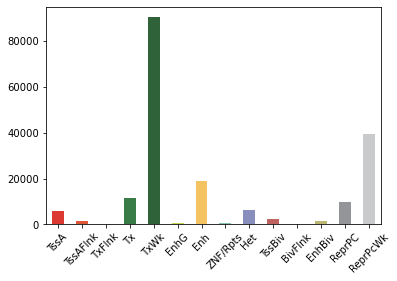

In [68]:
ax1=count_all_renamed.loc[:,"chr22"][:-1].plot.bar(rot=45, color=color_dec)  # except for Quies

In [43]:
# df_test=json.load("./cell_json/df_cell001.json")
# df_test